In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [2]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
from sklearn.utils import shuffle
fliter = (df["Usage"] == "Training")
df_train = pd.DataFrame(df[fliter])
print(df_train.shape)
df_train = shuffle(df_train)
df_train.head()

(28709, 3)


,emotion,pixels,Usage
18242,4,55 64 64 47 46 14 11 41 40 14 59 59 49 29 20 2...,Training
28249,3,86 84 64 41 41 33 14 9 8 10 6 23 59 90 113 136...,Training
5141,3,59 53 98 136 95 129 73 57 88 91 93 121 95 103 ...,Training
13923,2,23 23 23 21 22 22 22 23 32 39 50 51 38 38 29 2...,Training
14975,4,221 187 200 158 119 183 208 208 210 214 218 21...,Training


In [5]:
fliter2 = (df["Usage"] == "PublicTest")
df_test = pd.DataFrame(df[fliter2])
print(df_test.shape)
df_test.head()

(3589, 3)


,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [6]:
df_train.emotion.unique()

array([4, 3, 2, 0, 6, 5, 1])

In [7]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [8]:
df_train.emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

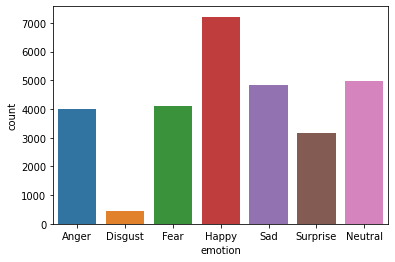

In [9]:
sns.countplot(df_train.emotion)
plt.savefig('emotion.png')
plt.xticks(range(0, 7),['Anger', 'Disgust', 'Fear', 'Happy', 'Sad','Surprise','Neutral'])
plt.show()

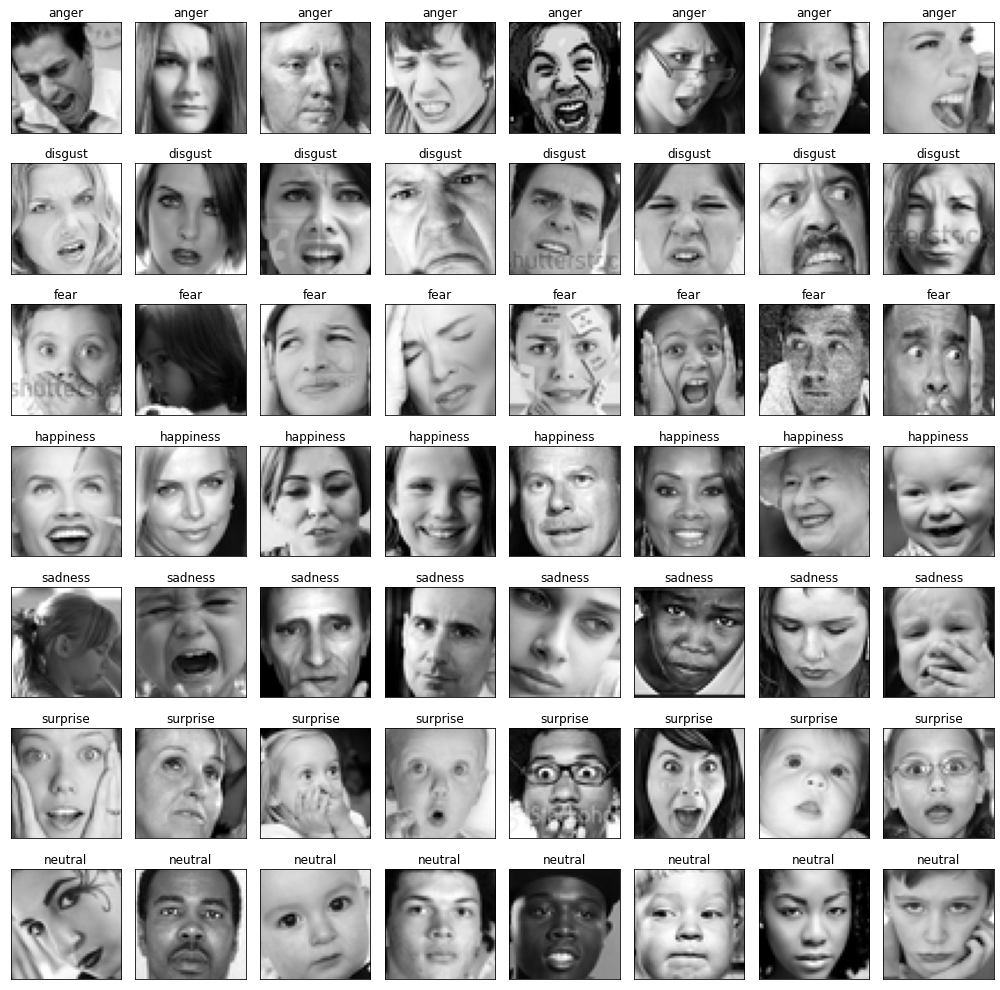

In [10]:
fig = plt.figure(1, (14, 14))
# pixel大小為48*48
k = 0
for label in sorted(df_train.emotion.unique()):
    for j in range(8):
        px = df_train[df_train.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 8, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

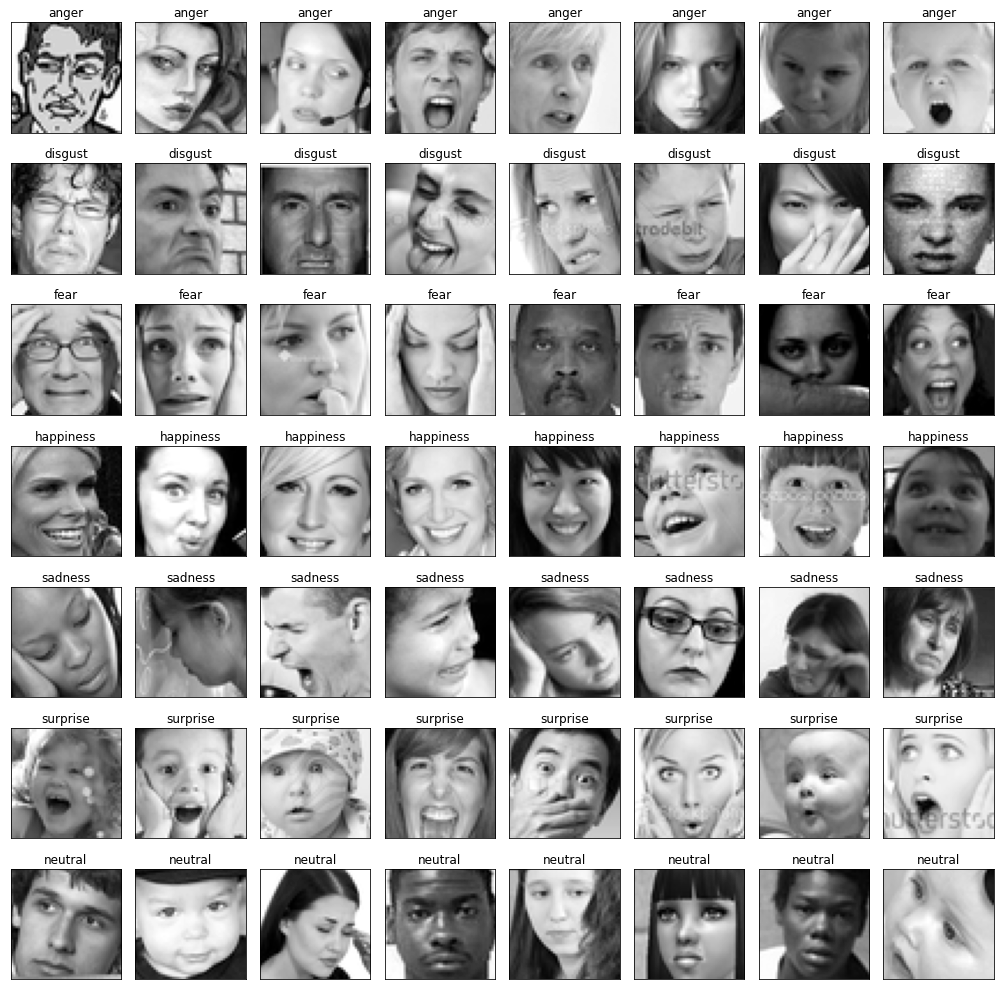

In [11]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df_test.emotion.unique()):
    for j in range(8):
        px = df_test[df_test.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 8, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [12]:
df_train.shape

(28709, 3)

In [13]:
df_test.shape

(3589, 3)

In [14]:
# 把資料存成要拿來訓練的型態
img_array_train = df_train.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array_test = df_test.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
#img_array_train

In [15]:
img_array_train = np.stack(img_array_train, axis=0)
img_array_train.shape

(28709, 48, 48, 1)

In [16]:
img_array_test = np.stack(img_array_test, axis=0)
img_array_test.shape

(3589, 48, 48, 1)

In [17]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder(handle_unknown='ignore')
enc = LabelEncoder()

img_labels_train = enc.fit_transform(df_train.emotion)
img_labels_train = np_utils.to_categorical(img_labels_train)
img_labels_train.shape

(28709, 7)

In [18]:
img_labels_test = enc.fit_transform(df_test.emotion)
img_labels_test = np_utils.to_categorical(img_labels_test)
img_labels_test.shape

(3589, 7)

In [19]:
le_name_mapping = dict(zip(enc.classes_, enc.transform(enc.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [20]:
# 分訓練資料和驗證資料
X_train, X_valid, y_train, y_valid = train_test_split(img_array_train, img_labels_train,
                                                    shuffle=True, stratify=img_labels_train,
                                                    test_size=0.1, random_state=42)
X_test  = img_array_test
y_test  = img_labels_test 
X_train.shape, X_valid.shape,  X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((25838, 48, 48, 1),
 (2871, 48, 48, 1),
 (3589, 48, 48, 1),
 (25838, 7),
 (2871, 7),
 (3589, 7))

In [21]:
del df
del df_train
del img_array_train
del img_labels_train
del img_array_test
del img_labels_test

In [22]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
img_depth

1

In [23]:
# Normalizing 
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

In [24]:
# model 架構
# CNN 為較淺層的CNN
# DCNN 為較深層的CNN

def build_model(optim):

    model = Sequential(name='CNN')

    model.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    model.add(Dropout(0.4, name='dropout_1'))

    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    model.add(BatchNormalization(name='batchnorm_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    model.add(Dropout(0.4, name='dropout_2'))

    model.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    model.add(BatchNormalization(name='batchnorm_3'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    model.add(Dropout(0.5, name='dropout_3'))

    model.add(Flatten(name='flatten'))
    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )   
    model.add(BatchNormalization(name='batchnorm_4'))
    
    model.add(Dropout(0.6, name='dropout_4'))
    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_2'
        )
    )
    model.add(BatchNormalization(name='batchnorm_5'))
    
    model.add(Dropout(0.6, name='dropout_5'))
    
    model.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    '''
    model = Sequential(name='DCNN')

    model.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    model.add(BatchNormalization(name='batchnorm_2'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    model.add(Dropout(0.4, name='dropout_1'))

    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    model.add(BatchNormalization(name='batchnorm_3'))
    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    model.add(BatchNormalization(name='batchnorm_4'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    model.add(Dropout(0.4, name='dropout_2'))

    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    model.add(BatchNormalization(name='batchnorm_5'))
    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    model.add(BatchNormalization(name='batchnorm_6'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    model.add(Dropout(0.5, name='dropout_3'))

    model.add(Flatten(name='flatten'))
        
    model.add(
        Dense(
            128,
            activation='relu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_7'))
    
    model.add(Dropout(0.6, name='dropout_4'))
    
    model.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    '''
    model.summary()
    
    return model

In [25]:

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [26]:
# 資料擴增
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [27]:
batch_size = 32 
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# optims 有 Nadam 和 Adam 兩種，目前是Adam
model = build_model(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 24, 24, 128)       512       
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 12, 12, 128)       0       

In [28]:
# 儲存model
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

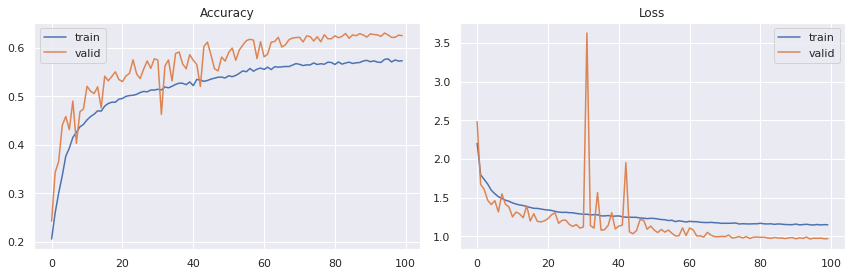

In [29]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

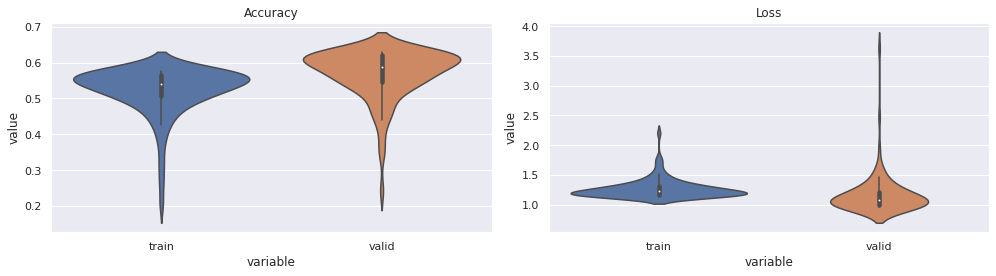

In [30]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = plt.figure(0, (14, 4))
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
plt.title('Loss')
plt.tight_layout()

plt.savefig('performance_dist.png')
plt.show()

total wrong validation predictions: 1078


              precision    recall  f1-score   support

           0       0.54      0.52      0.53       399
           1       1.00      0.16      0.27        44
           2       0.57      0.25      0.34       410
           3       0.81      0.88      0.84       722
           4       0.54      0.45      0.49       483
           5       0.70      0.78      0.74       317
           6       0.50      0.77      0.60       496

    accuracy                           0.62      2871
   macro avg       0.67      0.54      0.55      2871
weighted avg       0.63      0.62      0.61      2871



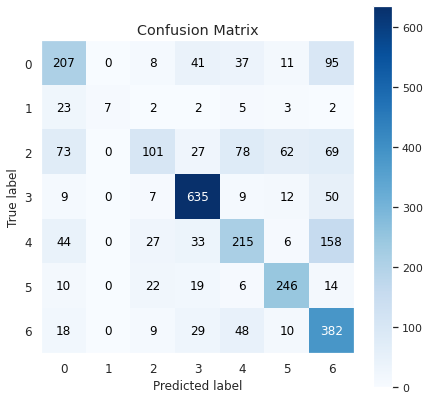

In [31]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
plt.savefig("valid_confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

total wrong test predictions: 1376


              precision    recall  f1-score   support

           0       0.52      0.55      0.54       467
           1       0.75      0.21      0.33        56
           2       0.56      0.22      0.32       496
           3       0.81      0.87      0.84       895
           4       0.55      0.43      0.48       653
           5       0.72      0.80      0.76       415
           6       0.47      0.73      0.57       607

    accuracy                           0.62      3589
   macro avg       0.62      0.55      0.55      3589
weighted avg       0.62      0.62      0.60      3589



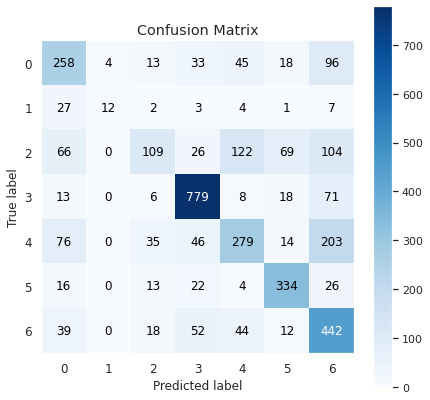

In [32]:

#prediction = model.predict_class(X_test)
yhat_test = model.predict_classes(X_test)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_test, figsize=(7,7))
plt.savefig("test_confusion_matrix_dcnn.png")

print(f'total wrong test predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_test))

In [33]:
mapper = {
    0:'anger',
    1:'disgust', 
    2:'fear',
    3:'happiness',
    4: 'sadness',
    5: 'surprise', 
    6: 'neutral'
}

In [34]:
np.random.seed(42)

random_imgs =[]
sizenum = 5
for j in range(7):
    random_img = np.random.choice(np.where(y_test[:, j]==1)[0], size=sizenum)
    random_imgs = np.concatenate([random_imgs,random_img])
    
#random_imgs

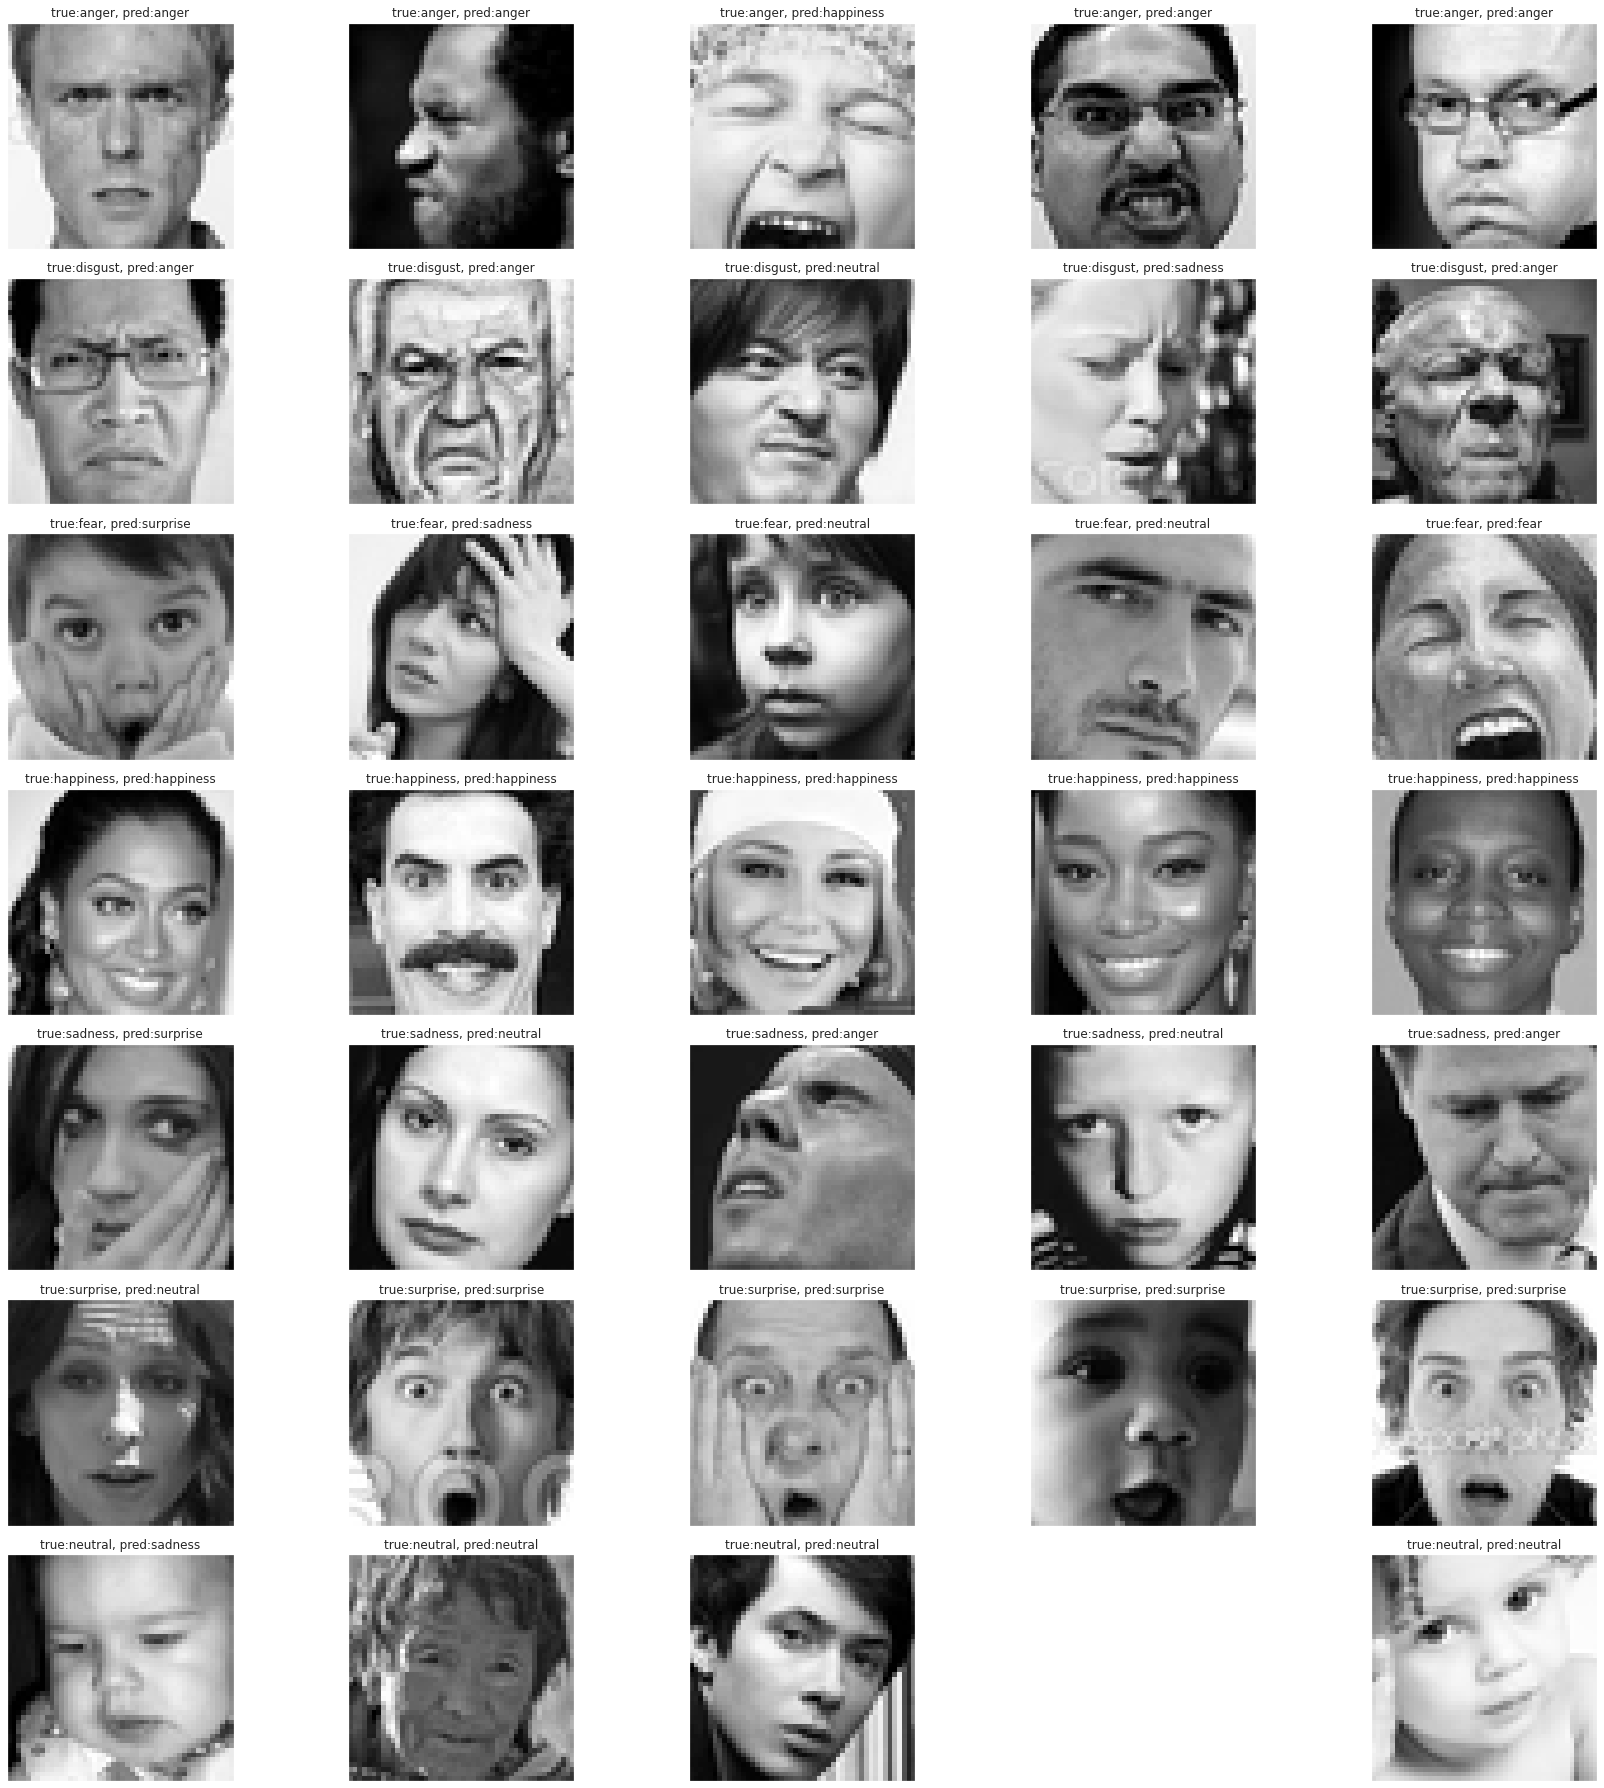

In [35]:
# 顯示出影像及預測結果
fig = plt.figure(1, (25, 25))


for i, idx in enumerate(random_imgs):
        idx
        ax = plt.subplot(7, sizenum, i+1)
        sample_img = X_test[int(idx),:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:{emotion_label_to_text[int(i/sizenum)]}, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        

        plt.tight_layout()